# Feature Basic Filtering

## Purpose
Apply basic filters to remove these problematic features:
- Extremly low coverage or high coverage features
- ENCODE Blcaklist
- Some chromosomes (usually, chrY and chrM)

## Input
- Cell metadata (after basic cell filter)
- MCDS files

## Output
- FeatureList.BasicFilter.txt: List of feature ids passed all filters

## Import

In [1]:
import pathlib
import pandas as pd
import seaborn as sns
from ALLCools.mcds import MCDS

In [2]:
sns.set_context(context='notebook', font_scale=1.3)

## Parameters

In [3]:
# change this to the path to your filtered metadata
metadata_path = 'CellMetadata.PassQC.csv.gz'

# change this to the paths to your MCDS files
mcds_path = '../../../data/Brain/snmC-seq2/Liu2021Nature.mcds'

# Dimension name used to do clustering
obs_dim = 'cell'  # observation
var_dim = 'chrom100k'  # feature

min_cov = 500
max_cov = 3000

# change this to the path to ENCODE blacklist.
# The ENCODE blacklist can be download from https://github.com/Boyle-Lab/Blacklist/
black_list_path = '../../../data/genome/mm10-blacklist.v2.bed.gz'
f = 0.2

exclude_chromosome = ['chrM', 'chrY']

## Load Data

### Metadata

In [4]:
metadata = pd.read_csv(metadata_path, index_col=0)
total_cells = metadata.shape[0]
print(f'Metadata of {total_cells} cells')

Metadata of 16985 cells


In [5]:
metadata.head()

,AllcPath,mCCCFrac,mCGFrac,mCGFracAdj,mCHFrac,mCHFracAdj,FinalReads,InputReads,MappedReads,DissectionRegion,BamFilteringRate,MappingRate,Plate,Col384,Row384,FANSDate,Slice,Sample
10E_M_0,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.008198,0.822633,0.821166,0.041640,0.033718,1626504.0,4407752,2892347.0,10E,0.562347,0.656195,CEMBA190625-10E-1,0,0,190625,10,10E_190625
10E_M_1,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006019,0.743035,0.741479,0.024127,0.018218,2009998.0,5524084,3657352.0,10E,0.549577,0.662074,CEMBA190625-10E-1,0,1,190625,10,10E_190625
10E_M_10,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006569,0.750172,0.748520,0.027665,0.021235,1383636.0,3455260,2172987.0,10E,0.636744,0.628892,CEMBA190625-10E-1,19,0,190625,10,10E_190625
10E_M_101,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006353,0.760898,0.759369,0.026547,0.020323,2474670.0,7245482,4778768.0,10E,0.517847,0.659551,CEMBA190625-10E-1,18,3,190625,10,10E_190625
10E_M_102,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005409,0.752980,0.751637,0.019497,0.014164,2430290.0,7004754,4609570.0,10E,0.527227,0.658063,CEMBA190625-10E-1,19,2,190625,10,10E_190625


### MCDS

In [6]:
mcds = MCDS.open(mcds_path, 
                 var_dim='chrom100k', 
                 use_obs=metadata.index)
total_feature = mcds.get_index(var_dim).size

In [7]:
mcds

<xarray.MCDS>
Dimensions:              (cell: 16985, chrom100k: 27269, count_type: 2, mc_type: 2)
Coordinates:
  * cell                 (cell) <U10 '10E_M_207' '10E_M_338' ... '9J_M_2969'
  * chrom100k            (chrom100k) int64 0 1 2 3 4 ... 27265 27266 27267 27268
    chrom100k_bin_end    (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
    chrom100k_bin_start  (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
    chrom100k_chrom      (chrom100k) <U5 dask.array<chunksize=(27269,), meta=np.ndarray>
  * count_type           (count_type) <U3 'mc' 'cov'
  * mc_type              (mc_type) <U3 'CGN' 'CHN'
    strand_type          <U4 'both'
Data variables:
    chrom100k_da         (cell, chrom100k, mc_type, count_type) uint16 dask.array<chunksize=(3397, 2479, 2, 2), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  chrom100k

## Filter Features

### Filter by mean coverage

Feature chrom100k mean cov across cells added in MCDS.coords['chrom100k_cov_mean'].


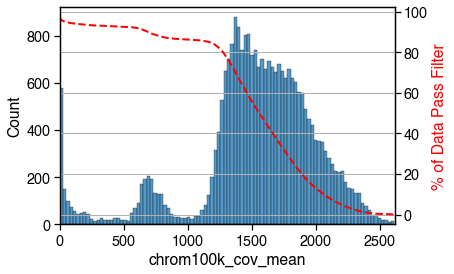

In [8]:
mcds.add_feature_cov_mean()

In [9]:
mcds = mcds.filter_feature_by_cov_mean(
    min_cov=min_cov,  # minimum coverage
    max_cov=max_cov  # Maximum coverage
)

Before cov mean filter: 27269 chrom100k
 After cov mean filter: 25242 chrom100k 92.6%


### Filter by ENCODE Blacklist

In [10]:
mcds = mcds.remove_black_list_region(
    black_list_path=black_list_path,
    f=f  # Features having overlap > f with any black list region will be removed.
)

1189 chrom100k features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


### Remove chromosomes

In [11]:
mcds = mcds.remove_chromosome(exclude_chromosome)

20 chrom100k features in ['chrM', 'chrY'] removed.


## Save Feature List

In [12]:
print(
    f'{mcds.get_index(var_dim).size} ({mcds.get_index(var_dim).size * 100 / total_feature:.1f}%) '
    f'{var_dim} remained after all the basic filter.')

24045 (88.2%) chrom100k remained after all the basic filter.


In [13]:
with open('FeatureList.BasicFilter.txt', 'w') as f:
    for var in mcds.get_index(var_dim).astype(str):
        f.write(var + '\n')

In [14]:
mcds

<xarray.MCDS>
Dimensions:              (cell: 16985, chrom100k: 24045, count_type: 2, mc_type: 2)
Coordinates:
  * cell                 (cell) <U10 '10E_M_207' '10E_M_338' ... '9J_M_2969'
  * chrom100k            (chrom100k) int64 30 31 32 33 ... 26335 26336 26337
    chrom100k_bin_end    (chrom100k) int64 dask.array<chunksize=(24045,), meta=np.ndarray>
    chrom100k_bin_start  (chrom100k) int64 dask.array<chunksize=(24045,), meta=np.ndarray>
    chrom100k_chrom      (chrom100k) <U5 dask.array<chunksize=(24045,), meta=np.ndarray>
  * count_type           (count_type) <U3 'mc' 'cov'
  * mc_type              (mc_type) <U3 'CGN' 'CHN'
    strand_type          <U4 'both'
    chrom100k_cov_mean   (chrom100k) float64 1.4e+03 1.378e+03 ... 715.3 696.9
Data variables:
    chrom100k_da         (cell, chrom100k, mc_type, count_type) uint16 dask.array<chunksize=(3397, 2364, 2, 2), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  chrom100k